In [1]:
import constants, Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
myCmap=sns.diverging_palette(170, 330, l=65, center="dark", as_cmap=True)
physical = {constants.SHOCK: ['Time', 'Density', 'gasTemp', 'av', 'zeta', 'radfield', constants.SHOCKVEL],
            constants.HOTCORE: ['Time', 'Density', 'gasTemp', 'av', 'zeta', 'radfield']}
species=['#CH3OH', 'CH3OH', '#SIO', 'SIO']

In [27]:
def buildDataframe(tipo): 
    df= pd.read_csv(tipo+'.csv', index_col=0)

    df = df.loc[:,physical[tipo]+species+['runName']]
    for prop in physical[tipo]+species:
        with np.errstate(divide='ignore'): df[f'{prop}_log']=np.log10(df[prop])
    
    df=df.reset_index().drop(columns=['index'])
    df=df.join(pd.DataFrame(df['runName'].str.replace('.dat','').str.split('_').values.tolist(), columns=constants.initparams[tipo]))
    return df

In [28]:
tipo=constants.HOTCORE

df=buildDataframe(tipo)
df

,Time,Density,gasTemp,av,zeta,radfield,#CH3OH,CH3OH,#SIO,SIO,...,zeta_log,radfield_log,#CH3OH_log,CH3OH_log,#SIO_log,SIO_log,cosmicRay,interstellarRad,iDens,fTemp
0,10.0,100000000.0,15.05,96440.00,1000.0,1000.0,2.946240e-07,8.956910e-10,1.416570e-14,1.140640e-13,...,3.0,3.0,-6.530732,-9.047842,-13.848762,-12.942851,1000.0,1000.0,100000000.0,300.0
1,100.0,100000000.0,15.37,96440.00,1000.0,1000.0,4.232610e-07,2.281880e-09,1.047690e-13,4.812050e-11,...,3.0,3.0,-6.373392,-8.641707,-12.979767,-10.317670,1000.0,1000.0,100000000.0,300.0
2,1000.0,100000000.0,17.59,96440.00,1000.0,1000.0,5.762970e-07,7.364640e-09,2.482430e-13,4.747750e-09,...,3.0,3.0,-6.239354,-8.132848,-12.605123,-8.323512,1000.0,1000.0,100000000.0,300.0
3,10000.0,100000000.0,32.89,96440.00,1000.0,1000.0,5.317030e-07,3.446380e-08,2.273830e-13,6.821850e-08,...,3.0,3.0,-6.274331,-7.462637,-12.643242,-7.166098,1000.0,1000.0,100000000.0,300.0
4,10100.0,100000000.0,33.04,96440.00,1000.0,1000.0,8.857940e-07,6.891740e-08,1.319240e-13,6.883850e-08,...,3.0,3.0,-6.052667,-7.161671,-12.879676,-7.162169,1000.0,1000.0,100000000.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,960100.0,1000000.0,50.00,966.37,10.0,1000.0,2.980820e-07,4.919300e-08,2.428850e-14,7.511740e-07,...,1.0,3.0,-6.525664,-7.308097,-13.614599,-6.124259,10.0,1000.0,1000000.0,50.0
1619,970100.0,1000000.0,50.00,966.37,10.0,1000.0,2.977740e-07,4.942150e-08,2.428750e-14,7.591080e-07,...,1.0,3.0,-6.526113,-7.306084,-13.614617,-6.119696,10.0,1000.0,1000000.0,50.0
1620,980100.0,1000000.0,50.00,966.37,10.0,1000.0,2.974660e-07,4.964720e-08,2.428640e-14,7.670370e-07,...,1.0,3.0,-6.526563,-7.304105,-13.614637,-6.115184,10.0,1000.0,1000000.0,50.0
1621,990100.0,1000000.0,50.00,966.37,10.0,1000.0,2.971590e-07,4.987010e-08,2.428540e-14,7.749610e-07,...,1.0,3.0,-6.527011,-7.302160,-13.614655,-6.110720,10.0,1000.0,1000000.0,50.0


# Primer intento

In [16]:
def getCorrMatrix(df, tipo, singleAxis):
    xaxis=[f'{prop}_log' for prop in species]
    yaxis= xaxis if singleAxis else [f'{prop}_log' for prop in physical[tipo]]

    cor = df.loc[:,xaxis if singleAxis else xaxis+yaxis].corr()
    cor=cor[cor.abs().ge(0.5)].loc[xaxis,yaxis].dropna(how='all').dropna(how='all', axis=1)
    return cor

In [17]:
def isValid(x, y):
    phases=['#','@','$']
    if x==y: return False
    elif x.strip('#@$')==y.strip('#@$'): return True
    for sym in phases:
        if sym in x and sym in y: return True
    return False

def getCorrValues(df, tipo, corrList, singleAxis):
    cor=getCorrMatrix(df, tipo, singleAxis)

    for i in cor.index:
        for j in cor.columns:
            if not np.isnan(cor.loc[i,j]):
                x=j.replace('_log','')
                y=i.replace('_log','')
                if singleAxis:
                    if isValid(x,y): corrList.append(pd.DataFrame(data={'tipo': tipo, 'x': x, 'y': y, 'coef': cor.loc[i,j]}, index=[0]))
                else: corrList.append(pd.DataFrame(data={'tipo': tipo, 'x': x, 'y': y, 'coef': cor.loc[i,j]}, index=[0]))

In [ ]:
corrList=[]
for tipo in physical:
    df=buildDataframe(tipo)
    for singleAxis in [False, True]:
        Plotting.getCorrValues(df, tipo, corrList, singleAxis)

corrs=pd.concat(corrList, ignore_index=True)

# pruebas

In [56]:
tipo=constants.SHOCK

df=buildDataframe(tipo)
df

In [ ]:
yaxis= [f'{prop}_log' for prop in species]
if singleAxis: xaxis=yaxis
else: xaxis= [f'{prop}_log' for prop in physical[tipo]]

corr, fig = Plotting.corrGrid(df, xaxis, yaxis, tipo, 0)
xaxis, yaxis = Plotting.getCorrValues(corr, singleAxis)

In [22]:
xaxis = [prop.replace('_log','') for prop in xaxis]
yaxis = [prop.replace('_log','') for prop in yaxis]


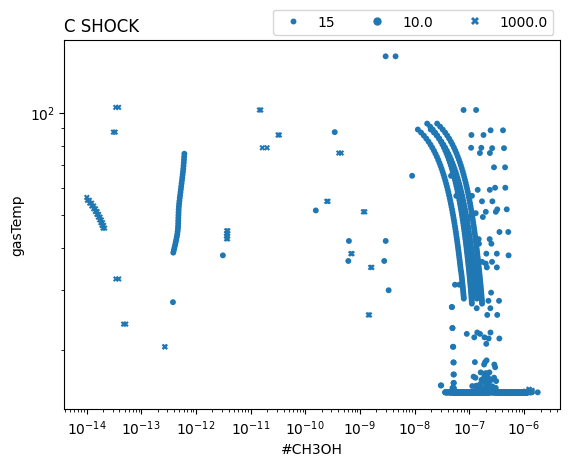

In [52]:
title=tipo
logxscale=False
logyscale=False

for i, phys in enumerate(xaxis):
    spec=yaxis[i]
    ax=sns.scatterplot(df,x=phys,y=spec,
                    # hue='zeta', palette='Spectral',
                    style='zeta',
                    linewidth=0, size=15
                    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper right',ncols=6, bbox_to_anchor=(1, 1.1))
    ax.set_title(title.upper(), loc='left')